In [1]:
import sqlite3
import pandas as pd
import os
import sys
from Bio.SubsMat import MatrixInfo as matlist
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from Bio.Data import CodonTable
from Bio.Seq import translate
import math
import numpy as np
def fasta2List(pathFasta):
    f = open(pathFasta, "r")
    title = []
    seq = []
    seq_temp = []
    for line in f:
        if line[0] == ">":
            seq.append(''.join(seq_temp).replace("\n", ""))
            title.append(line.replace("\n", ""))
            seq_temp = []
        else:
            seq_temp.append(line)
    seq.append(''.join(seq_temp).replace("\n", ""))
    seq.pop(0)
    dictionary = dict(zip(title, seq))
    return dictionary

conn = sqlite3.connect('../../mismatch_db.db')

In [14]:
# Fichier pour Nicolas
import sqlite3
import pandas as pd
conn = sqlite3.connect('mismatch_db.db')
transcript_df = pd.read_sql_query(
"""SELECT transcript.*, protein.prot_ID, protein.sequence 
FROM transcript
JOIN protein ON transcript.transcript_ID = protein.transcript_ID""", conn)
transcript_df = transcript_df.reindex(["prot_ID", "sequence", "transcript_ID", "sequence_genomic", "sequence_CDS"], axis=1)
# transcript_df.to_csv("../../temp/nico/prot_transcript_seq.csv", sep="\t", index=False)

In [3]:
mismatch = pd.read_sql_query("SELECT * FROM mismatch", conn)
mismatch = mismatch.astype({"exon_start_prim": "Int64", "exon_stop_prim":"Int64", "exon_start_hum": "Int64", "exon_stop_hum":"Int64"})

prim_exon_introns = pd.read_sql_query("""
SELECT mismatch_ID, mismatch.prot_prim, exon_intron_map.'type', exon_intron_map.number_elem, exon_intron_map.seq
FROM mismatch
JOIN protein ON mismatch.prot_prim = protein.prot_ID
JOIN transcript ON protein.transcript_ID = transcript.transcript_ID
JOIN exon_intron_map ON transcript.transcript_ID = exon_intron_map.transcript_ID
""", conn)

mismatch_prot_transcript = pd.read_sql_query(
"""SELECT * 
FROM mismatch
JOIN protein ON mismatch.prot_prim = protein.prot_ID
JOIN transcript ON protein.transcript_ID = transcript.transcript_ID""", conn)

mismatch_to_correct = pd.read_sql_query(
"""SELECT mismatch.*
FROM mismatch_flag 
JOIN tblastn_match ON mismatch_flag.mismatch_ID = tblastn_match.mismatch_ID 
JOIN mismatch on mismatch_flag.mismatch_ID = mismatch.mismatch_ID 
WHERE (one_hum_multiple_prim = 1
OR non_canonical_hum_spl = 1
OR N_in_genomic = 1
OR small_introns = 1)
AND conserved = 0
AND repeats_prot = 0
AND alignement_error = 0
AND human_isoform_exist = 0
""", conn)

tblastn = pd.read_sql_query(
"""SELECT tblastn_match.*
FROM tblastn_match 
JOIN mismatch_flag ON mismatch_flag.mismatch_ID = tblastn_match.mismatch_ID 
WHERE (one_hum_multiple_prim = 1
OR non_canonical_hum_spl = 1
OR N_in_genomic = 1
OR small_introns = 1)
AND conserved = 0
AND repeats_prot = 0
AND alignement_error = 0
AND human_isoform_exist = 0
""", conn)

protein_df = pd.read_sql_query(
"""SELECT * 
FROM protein
""", conn)

In [36]:
protein_df.loc[protein_df["prot_ID"] == row[1]].iloc[0, 1]

'MSEREERRFVEIPRESVRLMAESTGLELSDEVAALLAEDVCYRLREATQNSSQFMKHTKRRKLTVEDFNRALRWSSVEAVCGYGSQEALPMRPAREGELYFPEDREVNLVELALATNIPKGCAETAVRVHVSYLDGKGNLAPQGSVPSAVSSLTDDLLKYYHQVTRAVLGDDPQLMKVALQDLQTNSKIGALLPYFVYVVSGVKSVSHDLEQLHRLLQVARSLFRNPHLCLGPYVRCLVGSVLYCVLEPLAASINPLNDHWTLRDGAALLLSHIFWTHGDLVSGLYQHILLSLQKILADPVRPLCCHYGAVVGLHALGWKAVERVLYPHLSTYWTNLQAVLDDYSVSNAQVKADGHKVYGAILVAVERLLKMKAQAAEPNRGGPGGRGCRRLDDLPWDSLLFQESSSGGGAEPSFGSGLPLPPGGAGPEDPSLSVTLADIYRELYAFFGDSLATRFGTGQPAPTAPRPPGDKKEPAAAPDSVRKMPQLTASAIVSPHGDESPRGSGGGGPASASGPAASESRPLPRVHRARGAPRQQGPGTGTRDVFQKSRFAPRGAPHFRFIIAGRQAGRRCRGRLFQTAFPAPYGPSPASRYVQKLPMIGRTSRPARRWALSDYSLYLPL'

In [64]:
# SCRIPT DE CORRECTION DES MISMATCH
total = 0
error_big = 0
error_fus = 0
error_fus3 = 0
total_OK = 0
codon_stop = 0
bug_bizarre = 0

for index, row in mismatch_to_correct.iloc[:,:].iterrows():
    transcript_map = prim_exon_introns.loc[(prim_exon_introns["mismatch_ID"] == int(row[0])) & (prim_exon_introns["type"] == "Exon")]
    id_exon_start = row[7]-1
    id_exon_stop = row[8]
    mismatch_peptid = row[11]
    
    # LOCALISATION EXACT DES MISMATCH
    mismatch_exon_table = transcript_map.iloc[id_exon_start:id_exon_stop]
    mismatch_exon = transcript_map.iloc[id_exon_start:id_exon_stop, 4]
    exon_seq = mismatch_exon.str.cat(sep="")
    for i in range(3):
        peptid = translate(exon_seq[i:])
        frame = i
        match_find = peptid.find(row[11])
        if match_find != -1:
            break
    start_nuc_mismatch = match_find*3+frame
    stop_nuc_mismatch = match_find*3+len(mismatch_peptid*3)+frame
    
    # CREATION DES COORDONEE NUCLEOTIDES DES EXONS A MISMATCH
    taille_exon = []
    for index2, row2 in mismatch_exon_table.iloc[:,:].iterrows():
        taille_exon.append(len(row2[4]))
    taille_exon_fin = [sum(taille_exon[:x+1]) for x in range(0,len(taille_exon))]
    taille_exon_debut = taille_exon_fin.copy()
    taille_exon_debut.pop()
    taille_exon_debut[:]=[i+1 for i in taille_exon_debut]
    taille_exon_debut.insert(0, 0)
    mismatch_exon_table["pos_start"] = taille_exon_debut
    mismatch_exon_table["pos_stop"] = taille_exon_fin
    
    # SUPPRESSION DES PARTIE D'EXON DES TRANSCRIPT
    exon_seq = transcript_map.iloc[:, 4].str.cat(sep="")
    #print(transcript_map)
    #print(translate(exon_seq[:]))
    #print("*")
    #print(row[0])
    #print(frame)
    #print("*")
    for index2, row2 in mismatch_exon_table.iloc[:,:].iterrows():
        if row2[5] >= start_nuc_mismatch and row2[6] <= stop_nuc_mismatch:
            #print("TO DELETE TOTALLY", row2[3], index)
            conditional_index = transcript_map.loc[ transcript_map['number_elem'] == row2[3] ].index
            transcript_map.loc[conditional_index, ["seq"]] = ""

        if row2[5] < start_nuc_mismatch and row2[6] < stop_nuc_mismatch:
            #print("DELETE THE END OF EXON", row2[3])
            conditional_index = transcript_map.loc[ transcript_map['number_elem'] == row2[3] ].index
            suppr = transcript_map.loc[conditional_index, "seq"].iloc[0][start_nuc_mismatch-row2[5]:]
            transcript_map.loc[conditional_index, ["seq"]] = transcript_map.loc[conditional_index, "seq"].iloc[0][:start_nuc_mismatch-row2[5]]
        if row2[5] > start_nuc_mismatch and row2[6] > stop_nuc_mismatch:
            #print("DELETE THE BEGIN OF EXON", row2[3])
            conditional_index = transcript_map.loc[ transcript_map['number_elem'] == row2[3] ].index
            suppr += transcript_map.loc[conditional_index, "seq"].iloc[0][:stop_nuc_mismatch-row2[5]+1]
            transcript_map.loc[conditional_index, ["seq"]] = transcript_map.loc[conditional_index, "seq"].iloc[0][stop_nuc_mismatch-row2[5]+1:]

        if row2[5] <= start_nuc_mismatch and row2[6] >= stop_nuc_mismatch:
            # 1er nvx exon 
            conditional_index = transcript_map.loc[ transcript_map['number_elem'] == row2[3] ].index
            transcript_map.loc[conditional_index, ["seq"]] = transcript_map.loc[conditional_index, "seq"].iloc[0][:start_nuc_mismatch-row2[5]]
            # 2e nvx exon exon X.5
            new_row = row2.copy()
            new_row[3] = new_row[3] + 0.5
            new_row[4] = new_row[4][stop_nuc_mismatch-new_row[5]:]
            row_df = pd.DataFrame(new_row)
            if len(row_df.index) > 1: row_df = row_df.T
            transcript_map = pd.concat([transcript_map, row_df], ignore_index=True)
            conditional_index = transcript_map.loc[ transcript_map['number_elem'] == row2[3]+0.5 ].index
            
    # CORRECTION
    myTblastnMatch = tblastn.loc[ tblastn["mismatch_ID"] == row[0] ]
    
    try:
        prim_exon = prim_exon_introns.loc[(prim_exon_introns["mismatch_ID"]==row[0]) & (prim_exon_introns["number_elem"].isin(range(row[7],row[8]+1))) & (prim_exon_introns["type"]=="Exon")]
        prim_intron = prim_exon_introns.loc[(prim_exon_introns["mismatch_ID"]==row[0]) & (prim_exon_introns["number_elem"].isin(range(row[7],row[8]))) & (prim_exon_introns["type"]=="Intron")]
    except:
        print("Error transcript")
    genomic_Seq = ""
    for i in range(0,row[8]+1-row[7]):
        genomic_Seq += prim_exon.iloc[i,4]
        try: genomic_Seq += prim_intron.iloc[i,4]
        except: pass
    tblastn_dna = genomic_Seq[myTblastnMatch.iloc[0, 5]+2:myTblastnMatch.iloc[0, 6]]
    
    # Splicing site check
    no_splicing_site = False
    splicing_5_pos = -1
    finish_splicing = False
    loop_value = [0, 1, 2, -1, -2]
    for i in loop_value:
        splicing_5 = genomic_Seq[myTblastnMatch.iloc[0, 5]-i*3:myTblastnMatch.iloc[0, 5]+2-i*3]
        if  splicing_5 == "AG":
            new_start = myTblastnMatch.iloc[0, 5]+2-i*3
            for j in loop_value:
                splicing_3 = genomic_Seq[myTblastnMatch.iloc[0, 6]+i*3:myTblastnMatch.iloc[0, 6]+2+i*3]
                if  splicing_3 == "GT":
                    new_stop = myTblastnMatch.iloc[0, 6]+i*3
                    tblastn_dna = genomic_Seq[new_start:new_stop]
                    finish_splicing = True
                    break
        if finish_splicing: break
        else:
            no_splicing_site = True
    
    if no_splicing_site: continue
    
    new_row_blast = row2.copy()
    new_row_blast[3] = row[7] + 0.25
    new_row_blast[4] = tblastn_dna
    if "*" in translate(tblastn_dna): 
        continue
    row_df_blast = pd.DataFrame(new_row_blast[:-2])
    if len(row_df_blast.index) > 1: row_df_blast = row_df_blast.T
    transcript_map = pd.concat([transcript_map, row_df_blast], ignore_index=True)

    transcript_map = transcript_map[transcript_map['seq'].map(len) > 0]
    transcript_map.sort_values(by="number_elem", inplace=True, ignore_index=True)
    transcript_map["number_elem"] = range(1, len(transcript_map.index)+1)
    exon_seq = transcript_map.iloc[:, 4].str.cat(sep="")
    
    # VERIFIER QUE LE TRANSCRIPT S'ENCHAINE BIEN
    exon_start = []
    exon_stop = []
    genomic = mismatch_prot_transcript.loc[mismatch_prot_transcript["mismatch_ID"]== row[0] ].iloc[0, 19]
    for index3, row3 in transcript_map.iloc[:,:].iterrows():
        exon_start.append(genomic.find(row3[4]))
        exon_stop.append(genomic.find(row3[4])+len(row3[4]))
    transcript_map["exon_start"] = exon_start
    transcript_map["exon_stop"] = exon_stop
    
    
    total +=1
    Error_switch = False
    for i in range(len(transcript_map.index)-1):
        if transcript_map.iloc[i, 6] > transcript_map.iloc[i+1, 5]:
            if transcript_map.iloc[i, 6]-transcript_map.iloc[i+1, 5] > 15 and len(transcript_map.iloc[i, 4])>=17 and len(transcript_map.iloc[i+1, 4])>=17:
                #print("Big error")
                #print(transcript_map.iloc[i, 4], len(transcript_map.iloc[i, 4]))
                #print(transcript_map.iloc[i+1, 4], len(transcript_map.iloc[i+1, 4]))
                error_big += 1
                Error_switch = True
                break
            elif transcript_map.iloc[i, 6]-transcript_map.iloc[i+1, 5] <= 15 and len(transcript_map.iloc[i, 4])>=17 and len(transcript_map.iloc[i+1, 4])>=17:
                #print("Fusion issue")
                #print(transcript_map.iloc[i, 6]-transcript_map.iloc[i+1, 5])
                if (transcript_map.iloc[i, 6]-transcript_map.iloc[i+1, 5])%3 == 0: error_fus3 +=1
                error_fus += 1
                Error_switch = True
                break
    if Error_switch == True: continue
    total_OK += 1
    
    # TRADUCTION DE PROT
    # Mapping de l'ancienne CDS
    old_cds = mismatch_prot_transcript.loc[mismatch_prot_transcript["mismatch_ID"]== row[0] ].iloc[0, 18]
    start_tri = exon_seq.find(old_cds[:45])
    
    # Si mapping foire on cherche la plus grand CDS contenant notre correction
    if start_tri == -1:
        frame = "Error"
        start = []
        stop = []
        CDS = []
        for i in range(3):
            prot_seq = translate(exon_seq[i:])
            if translate(tblastn_dna) in prot_seq:
                frame = i
                break
        correction = prot_seq.find(translate(tblastn_dna))
        if correction == -1: print("Error could not find tlbastn match in prot")
        old_prot = mismatch_prot_transcript.loc[mismatch_prot_transcript["mismatch_ID"]== row[0] ].iloc[0, 14]
        furthest_start = -1
        stop_pos = -1
        first_AA = -1
        for i in range(correction,0,-1):
            if prot_seq[i] == "M":
                furthest_start = i
            if prot_seq[i] == "*":
                stop_pos = i
                break
        if furthest_start == -1 and stop_pos == -1: first_AA = 0
        elif stop_pos < furthest_start: first_AA = furthest_start
        elif stop_pos > furthest_start: first_AA = stop_pos+1

        prot_seq = prot_seq[first_AA:]
        stop_codon = prot_seq.find("*")
        if stop_codon != -1: prot_seq = prot_seq[:stop_codon]
    
    # Sinon si le mapping à fonctionné, on crée la prot.
    else: 
        prot_seq = translate(exon_seq[start_tri:])
        # Bug bizarre sur 3 prot pour 600 qui n'ont pas pu etre corrigé au final ? A voir
        if translate(tblastn_dna) not in prot_seq:
            bug_bizarre += 1
            continue
        
        stop_codon = prot_seq.find("*")
        if stop_codon != -1: prot_seq = prot_seq[:stop_codon]

  
    #f = open("../../data/correction/two-by-two2/"+str(row[0])+"_"+row[1]+"_"+row[2]+".fasta", "w")
    f = open("../../data/correction/two-by-two2/"+row[1]+"_"+row[2]+".fasta", "w")
    f.write(">"+row[1]+"\n")
    f.write(protein_df.loc[protein_df["prot_ID"] == row[1]].iloc[0, 1]+"\n")
    f.write(">"+row[2]+"\n")
    f.write(prot_seq+"\n")
    f.close()
    
    #f = open("../../data/correction/two-by-two-old2/"+str(row[0])+"_"+row[1]+"_"+row[2]+".fasta", "w")
    f = open("../../data/correction/two-by-two-old2/"+row[1]+"_"+row[2]+".fasta", "w")
    f.write(">"+row[1]+"\n")
    f.write(protein_df.loc[protein_df["prot_ID"] == row[1]].iloc[0, 1]+"\n")
    f.write(">"+row[2]+"\n")
    f.write(protein_df.loc[protein_df["prot_ID"] == row[2]].iloc[0, 1]+"\n")
    f.close()

/home/meyer/anaconda3/envs/stage-env/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/meyer/anaconda3/envs/stage-env/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1]:
import glob
from Bio import AlignIO
import numpy as np

identity_score = []
old_identity_score = []
coverage = []
old_coverage = []

alignements_files = glob.glob('../../data/correction/two-by-two/*.mafft')
alignements_files_old = glob.glob('../../data/correction/two-by-two-old/*.mafft')
for files_id in range(len(alignements_files)):
    identity = 0
    old_identity = 0
    no_gap = 0
    no_gap_old = 0
    
    align = AlignIO.read(alignements_files[files_id], "fasta")
    for i in range(align.get_alignment_length()):
        if align[0][i] != "-" and align[1][i] != "-":
            no_gap += 1
        if align[0][i] == align[1][i]:
            identity += 1
    #identity_score.append(identity/align.get_alignment_length()*100)
    identity_score.append(identity/no_gap*100)
    coverage.append(no_gap/align.get_alignment_length()*100)
    
    align_old = AlignIO.read(alignements_files_old[files_id], "fasta")
    for i in range(align_old.get_alignment_length()):
        if align_old[0][i] != "-" and align_old[1][i] != "-":
            no_gap_old += 1
        if align_old[0][i] == align_old[1][i]:
            old_identity += 1
    #old_identity_score.append(old_identity/align_old.get_alignment_length()*100)
    old_identity_score.append(old_identity/no_gap_old*100)
    old_coverage.append(no_gap_old/align_old.get_alignment_length()*100)

In [3]:
print(np.mean(old_identity_score))
print(np.mean(identity_score))
print(np.mean(old_coverage))
print(np.mean(coverage))

91.95625264796031
95.09021328329614
89.40449282382119
90.67656818986796


In [8]:
diff = []
for i in range(len(identity_score)):
    if identity_score[i] - old_identity_score[i] > 30:
        print(alignements_files[i])
        print(alignements_files_old[i])
    diff.append(identity_score[i] - old_identity_score[i])

../../data/correction/two-by-two/O14772_H2N716.fasta.mafft
../../data/correction/two-by-two-old/O14772_H2N716.fasta.mafft


In [6]:
diff2 = []
for i in range(len(coverage)):
    if coverage[i] - old_coverage[i] > 40:
        print(alignements_files[i])
    diff2.append(coverage[i] - old_coverage[i])

../../data/correction/two-by-two/O14772_H2N716.fasta.mafft
../../data/correction/two-by-two/Q6ZNB5_H2NEJ2.fasta.mafft


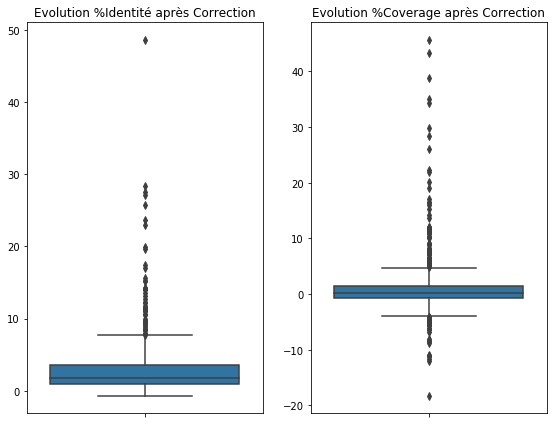

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
sns.boxplot(diff, orient="v", ax=ax1)
sns.boxplot(diff2, orient="v", ax=ax2)
ax1.set_title("Evolution %Identité après Correction")
ax2.set_title("Evolution %Coverage après Correction")
f.tight_layout()

In [2]:
mismatch_to_correct = pd.read_sql_query(
"""SELECT mismatch.*
FROM mismatch_flag
JOIN mismatch on mismatch_flag.mismatch_ID = mismatch.mismatch_ID 
WHERE (one_hum_multiple_prim = 1
OR non_canonical_hum_spl = 1
OR N_in_genomic = 1
OR small_introns = 1)
AND conserved = 0
AND repeats_prot = 0
AND alignement_error = 0
AND human_isoform_exist = 0
""", conn)

In [5]:
mismatch_to_correct
mismatch_to_correct.to_csv('../../temp/primate_errors_misprediction.csv', sep="\t", index = False)